In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

# 3. Select image patches for processing

In this short chapter, we will start working on mosaic composing. Before we 
start working on the matching algorithm, we have to prepare the processing 
framework.

We will be working on `MosaicImage` class from `mosaic_maker.mosaic.mosaic_image`
module.

We have two methods to implement there:
  - `_crop_image_to_patch_size`, that crops image so its completely divisible
  by our patch size - this is a brutal solution that will save us from 
  border-case headaches
  - `_select_patch_for`, that will use a `PatchPicker` class for selecting
  match for currently processed square and will print patch on the mosaic 
  image. `_select_patch_for` prints also some development info.
  
Displaying development info on images is common practice for debugging and
tracking computer vision algorithms behavior. We will display
the Sobel version of the image and mosaic to see if our algorithm persists 
edges well. We will also mark current progress by marking processed shapes 
with border.

Take a while for `MosaicImage` implementation analysis. As you will see, we're
using threads for its main loop. The reason is that we want to be able to
display current mosaic status during computation-heavy
operations. In order to prevent mosaic computation from blocking interface,
we put its logic to separate thread witch is a common practice in the systems 
with responsive GUI.

Let's start with cropping implementation. At this stage, you should be
acquainted with the `Numpy` well enough to crop source image, so it's 
fully divisible by the `PATCH_SIZE`.  

Remember to make `select_patch_for` return a new image instead of 
modifying the original one.

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mosaic_maker.mosaic.mosaic_image import MosaicImage
from mosaic_maker.mosaic.patch_picker import PatchPicker
from config import PATCH_SIZE, PROJECT_ROOT

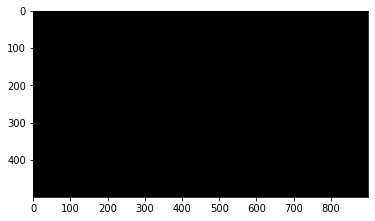

In [4]:
image_path = PROJECT_ROOT / 'assets/test-target.jpg'
test_image = cv2.imread(image_path.as_posix())
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

original shape: (500, 900, 3)
cropped shape: (500, 900, 3)


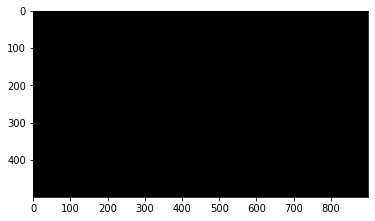

In [5]:
test_image_copy = test_image.copy()

cropped_image = MosaicImage._crop_image_to_patch_size(test_image_copy, PATCH_SIZE)
print(f'original shape: {test_image_copy.shape}')
print(f'cropped shape: {cropped_image.shape}')
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

The next step will be a bit more sophisticated. We want to modify 
`_select_patch_for` method so it:
  - creates patch class instance for provided `(x, y)` position
  - feeds it to `PatchPicker` `pick_patch_for` method to select mosaic patch
   (currently `pick_patch_for` isn't implemented, so it always returns a random
   image from the sources set
  - prints corresponding images on `mosaic` and `sobel_mosaic`
  - prints corresponding rectangles on `target_image_copy` and 
  `target_sobel_image_copy`

In [6]:
test_image_copy = test_image.copy()

patches_path = PROJECT_ROOT / 'assets/indexed-sources/test'
patch_picker = PatchPicker('test', patches_path)
mosaic_image = MosaicImage(test_image_copy, PATCH_SIZE, patch_picker)

In [7]:
mosaic = np.zeros(mosaic_image.target_image.shape, np.uint8)
sobel_mosaic = np.zeros(mosaic_image.target_sobel_image.shape, np.uint8)

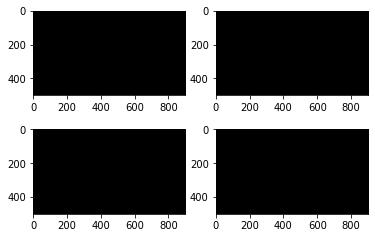

In [8]:
_, grid = plt.subplots(2, 2)
grid[0, 0].imshow(cv2.cvtColor(mosaic_image.target_image, cv2.COLOR_BGR2RGB))
grid[0, 1].imshow(mosaic_image.target_sobel_image, cmap='gray')
grid[1, 0].imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
grid[1, 1].imshow(sobel_mosaic, cmap='gray')

In [9]:
target_image_copy = mosaic_image.target_image.copy()
target_sobel_image_copy = mosaic_image.target_sobel_image.copy()

(height, width) = target_image_copy.shape[:2]
mosaic_image._compose_mosaic_for(width, height, 
                                 mosaic, sobel_mosaic, 
                                 target_image_copy, target_sobel_image_copy)

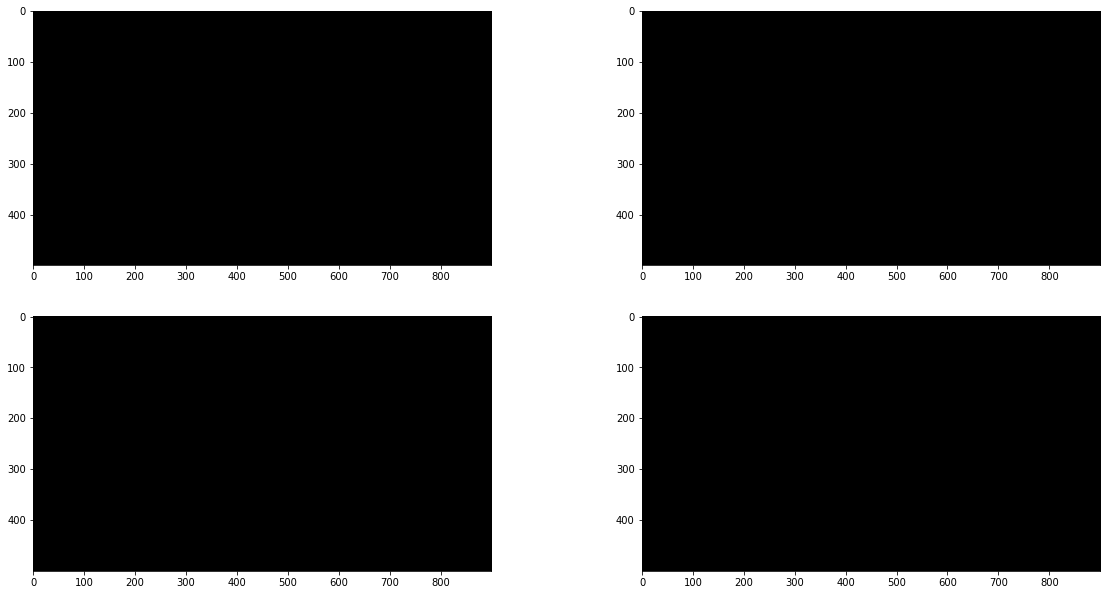

In [10]:
_, grid = plt.subplots(2, 2, figsize=(20, 10.3))
grid[0, 0].imshow(cv2.cvtColor(target_image_copy, cv2.COLOR_BGR2RGB))
grid[0, 1].imshow(target_sobel_image_copy, cmap='gray')
grid[1, 0].imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
grid[1, 1].imshow(sobel_mosaic, cmap='gray')

The result should be similar to this:

![title](assets/3-select-image/result.png)

The grid may not display fully due to `MatPlotLib` compression.

If you run `compose_mosaic` module main function, you should see mosaic
filling up dynamically, resulting in the following windows displayed:

![title](assets/3-select-image/modals-result.png)